# Сегментация клиентов

Так как мы не можете относиться к каждому клиенту одинаково с одним и тем же контентом, одним и тем же маркетинговым планом, одинаковой важностью, мы используем сегментацию клиентов

Можно выделять множество различных сегментов в соответствии с тем, чего мы пытаемся достичь. Если хотим увеличить коэффициент удержания, вы можете выполнить сегментацию на основе вероятности оттока и принять меры. Но существуют также очень распространенные и полезные методы сегментации. Теперь мы собираемся внедрить один из них в наш бизнес: **RFM**.

## Теоретическая сегментация по клиентам:
* **Клиенты с низкой ценностью**: Клиенты, которые менее активны, чем другие, не очень частые покупатели/посетители и приносят очень низкий - нулевой - возможно, отрицательный доход.
* **Клиенты со средней ценность**: В середине всего. Часто использует нашу платформу (но не так часто, как наши клиенты с высокой ценностью), довольно часто делают покупки и приносит умеренный доход.
* **Клиенты с высокой ценностью**: Группа, которую мы не хотим потерять. Высокий доход, хорошая частота покупок и высокая активность.

В качестве методологии нам необходимо рассчитать Давность посещения, частоту покупок и стоимость (отныне мы будем называть это доходом) и применить неконтролируемое машинное обучение для определения различных групп (кластеров) для каждой из них.

Чтобы рассчитать давность, нам нужно узнать самую последнюю дату покупки каждого клиента и посмотреть, сколько дней они неактивны. После того, как узнаем количество неактивных дней, для каждого клиента мы применим кластеризацию K-средних*, чтобы присвоить клиентам оценку за последнее время.

In [44]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from datetime import datetime, timedelta

In [45]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')
print(df.info())
print(df.isna().sum())
print('Дубликаты', df.duplicated().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Дубликаты 5268


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Кластерезуем время дваности клиентов

In [46]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_uk = df.query("Country == 'United Kingdom'").reset_index(drop=True)
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [47]:
df_users = pd.DataFrame(df['CustomerID'].unique())
df_users.columns = ['CustomerID']
df_users

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
...,...
4368,13436.0
4369,15520.0
4370,13298.0
4371,14569.0


In [48]:
df_max_purchase = df_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
df_max_purchase

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00
...,...,...
3945,18280.0,2011-03-07 09:52:00
3946,18281.0,2011-06-12 10:53:00
3947,18282.0,2011-12-02 11:43:00
3948,18283.0,2011-12-06 12:02:00


In [49]:
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days
df_max_purchase

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2
...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277
3946,18281.0,2011-06-12 10:53:00,180
3947,18282.0,2011-12-02 11:43:00,7
3948,18283.0,2011-12-06 12:02:00,3


In [50]:
df_users = pd.merge(df_users, df_max_purchase[['CustomerID','Recency']], on='CustomerID')
df_users

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25
...,...,...
3945,15471.0,1
3946,13436.0,1
3947,15520.0,1
3948,13298.0,0


In [51]:
df_users.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

Мы видим, что, хотя среднее значение составляет 90 дней, медиана составляет 49.

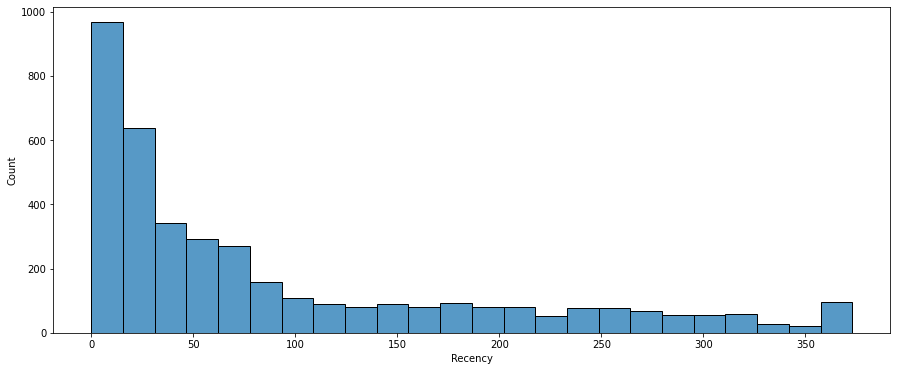

In [52]:
plt.subplots(figsize=(15, 6))
sns.histplot(df_users['Recency'])

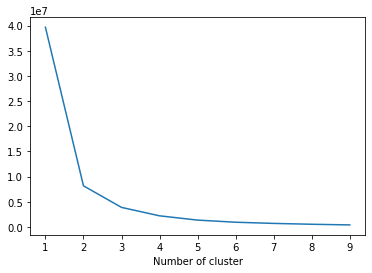

In [53]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_users[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Здесь 3 группы являются оптимальным. Основываясь на бизнес-требованиях, мы можем использовать меньше или больше кластеров. Мы выберем 4 для этого примера:


In [54]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_users[['Recency']])
df_users['RecencyCluster'] = kmeans.predict(df_users[['Recency']])

def order_cluster(cluster_field_name, target_field_name, df_n, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df_n.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df_n,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_users = order_cluster('RecencyCluster', 'Recency', df_users, False)
df_users

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0
...,...,...,...
3945,15942.0,133,1
3946,14143.0,133,1
3947,16147.0,133,1
3948,15149.0,133,1


In [55]:
df_users.groupby(['RecencyCluster']).agg({'Recency' : 'describe'})


Recency                         ...                      
                 count        mean        std  ...    50%     75%    max
RecencyCluster                                 ...                      
0                478.0  304.393305  41.183489  ...  300.0  336.00  373.0
1                568.0  184.625000  31.753602  ...  184.0  211.25  244.0
2                954.0   77.679245  22.850898  ...   72.5   93.00  131.0
3               1950.0   17.488205  13.237058  ...   16.0   28.00   47.0

[4 rows x 8 columns]

### Кластерезуем частоту покупок
Для создания частотных кластеров нам нужно найти общее количество заказов для каждого клиента. 

In [56]:
df_frequency = df_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']
df_users = pd.merge(df_users, df_frequency, on='CustomerID')

In [57]:
df_users_graf = df_users.query("Frequency < 1000")

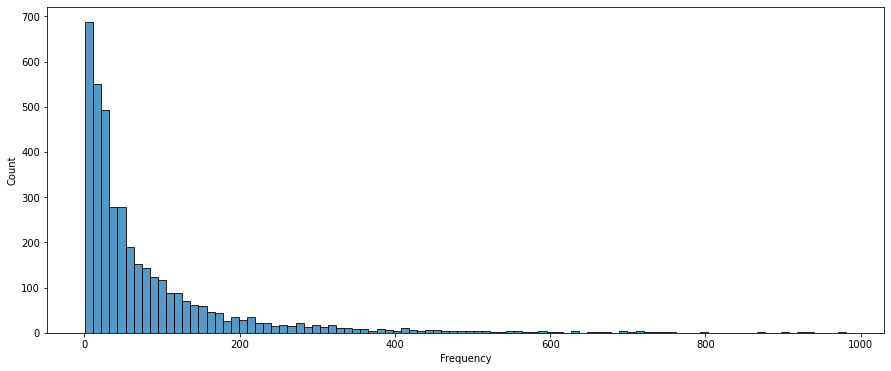

In [58]:
plt.subplots(figsize=(15, 6))
sns.histplot(df_users_graf['Frequency'])

In [59]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_users[['Frequency']])
df_users['FrequencyCluster'] = kmeans.predict(df_users[['Frequency']])
df_users = order_cluster('FrequencyCluster', 'Frequency',df_users,True)
df_users.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


In [60]:
df_uk['Revenue'] = df_uk['UnitPrice'] * df_uk['Quantity']
df_revenue = df_uk.groupby('CustomerID').Revenue.sum().reset_index()
df_users = pd.merge(df_users, df_revenue, on='CustomerID')

In [61]:
df_users_rev = df_users.query("Revenue < 20000")

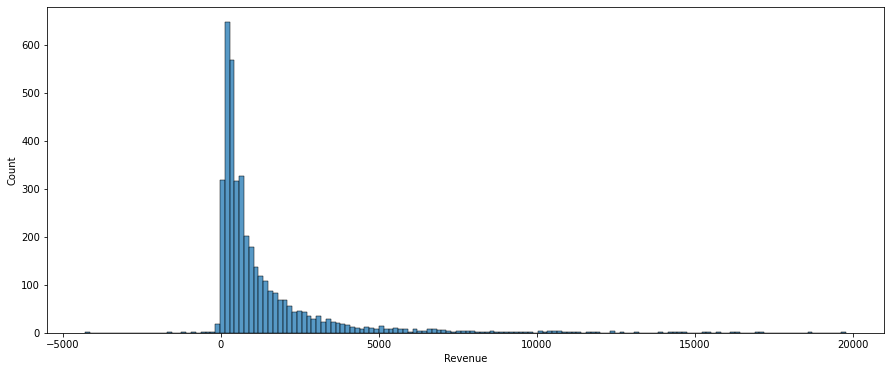

In [62]:
plt.subplots(figsize=(15, 6))
sns.histplot(df_users_rev['Revenue'])

У нас также есть некоторые клиенты с отрицательной выручкой. Давайте продолжим и применим кластеризацию k-средних:


In [63]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_users[['Revenue']])
df_users['RevenueCluster'] = kmeans.predict(df_users[['Revenue']])
df_users = order_cluster('RevenueCluster', 'Revenue',df_users,True)
df_users.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


In [64]:
df_users

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1
...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2
3946,17841.0,1,3,7983,3,40340.78,2
3947,14096.0,3,3,5128,3,57120.91,2
3948,17450.0,7,3,351,1,187482.17,3


In [65]:
df_users['OverallScore'] = df_users['RecencyCluster'] + df_users['FrequencyCluster'] + df_users['RevenueCluster']
df_users.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


Приведенный выше балл ясно показывает нам, что клиенты с 8 баллами являются нашими лучшими клиентами, в то время как 0-худшие.

### Чтобы все было проще, лучше назовем эти оценки:

* **Клиенты с низкой ценностью**: от 0 до 2.
* **Клиенты со средней ценность**: от 3 до 4.
* **Клиенты с высокой ценностью**: 5+.

In [66]:
df_users['Segment'] = 'Low-Value'
df_users.loc[df_users['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_users.loc[df_users['OverallScore']>4,'Segment'] = 'High-Value' 

In [67]:
df_users_graph = df_users.query("Frequency < 2000")

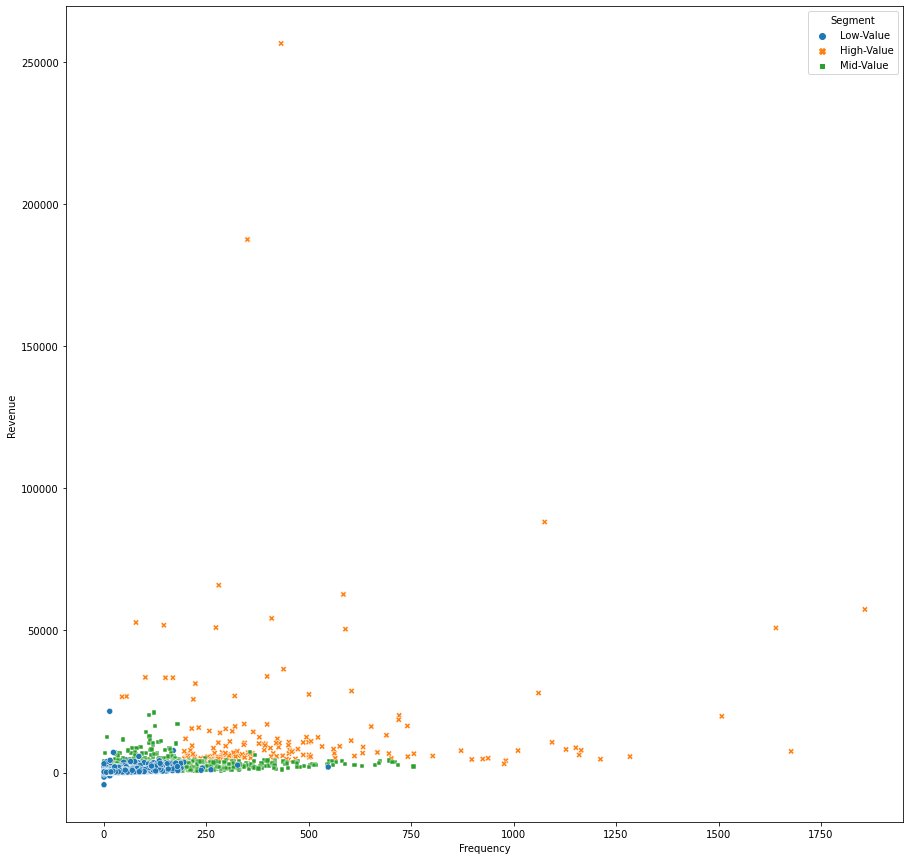

In [68]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(data=df_users_graph, x="Frequency", y="Revenue", hue="Segment", style="Segment")

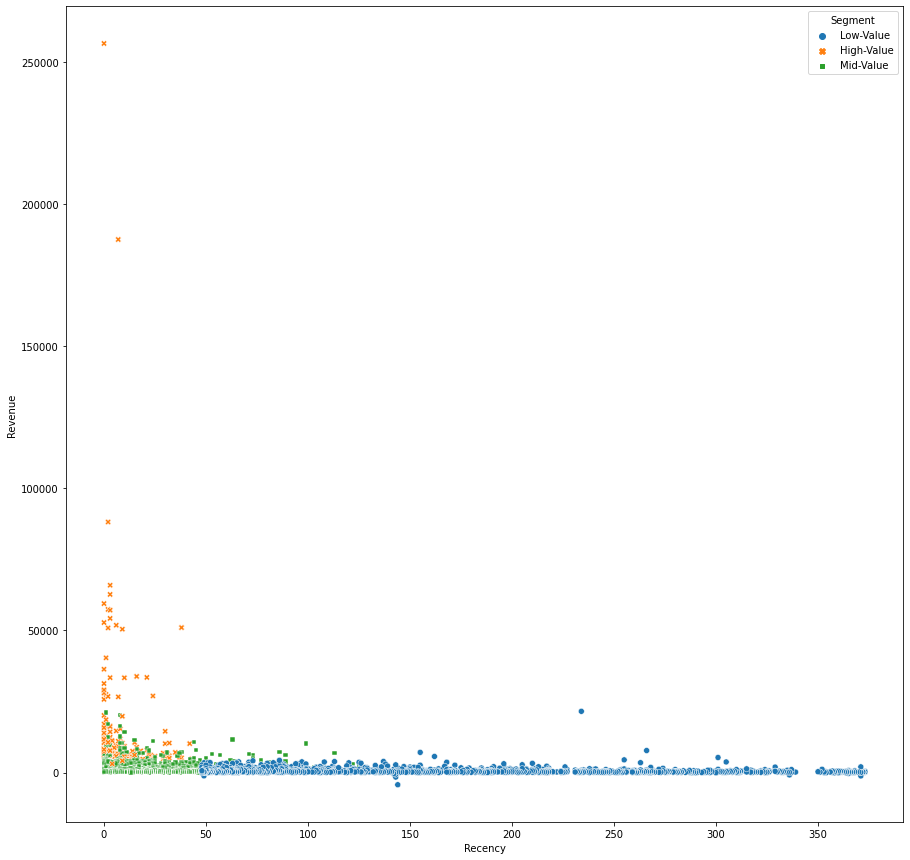

In [69]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(data=df_users, x="Recency", y="Revenue", hue="Segment", style="Segment")

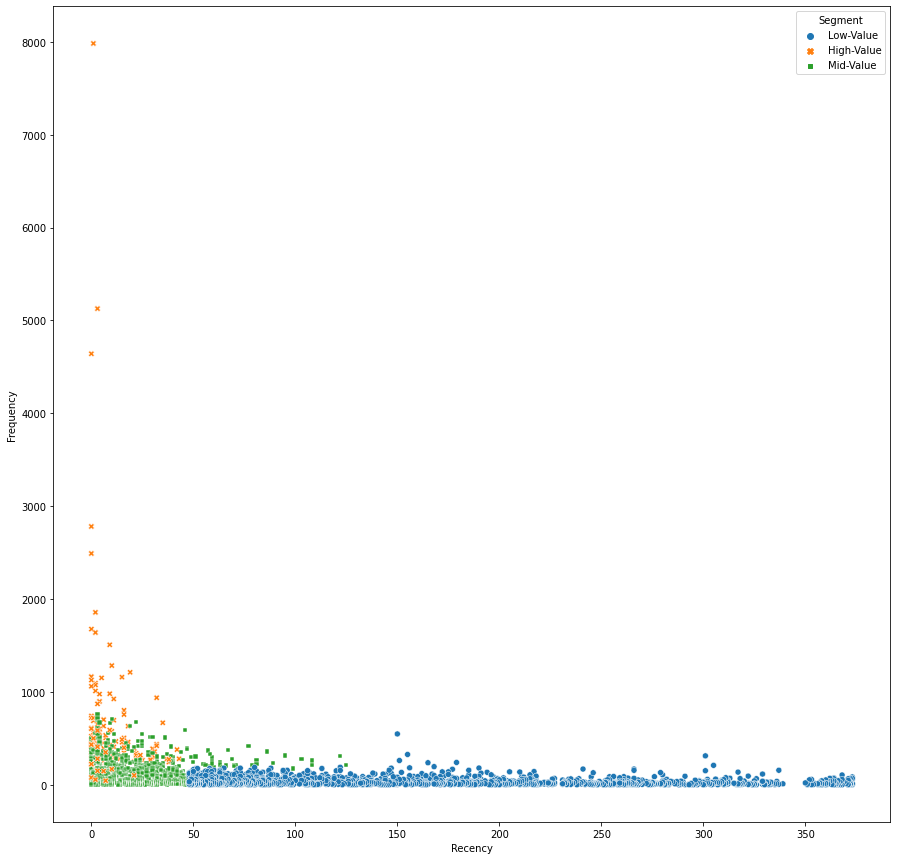

In [70]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(data=df_users, x="Recency", y="Frequency", hue="Segment", style="Segment")

### Мы можем начать предпринимать действия с помощью этой сегментации. Основные стратегии:

* **Клиенты с низкой ценностью**: Увеличение частоты покупок
* **Клиенты со средней ценность**: Улучшение Удержания + Увеличение Частоты покупок
* **Клиенты с высокой ценностью**: Улучшение Удержания